## Notebook to solve 1D elliptic, self adjoint eigenvalue problem

Here we solve a (formally) self adjoint, regular elliptic problem in 1D, the problem is of the form:

\begin{align}
    -\frac{d}{dx}(p(x)\frac{d}{dx}) + q(x) u(x) = \lambda r(x) u(x)
\end{align}

with $p(x) > 0$. We solve it in an interval $[0,L]$ and use boundary conditions $\{u_0=0, u_1=0\}$ at the left-right boundaries. 

In [45]:
import Pkg; Pkg.activate("../05_tarea/gridap_makie"); # activamos el proyecto "gridap_makie" donde se intalarán todos los paquetes
using Gridap;
using GridapGmsh;
using Gmsh;

# crear directorios en caso de no haberlo hecho
create_directories = false;
if (create_directories==true)
    mkdir("models");
    mkdir("images");
end

# en caso de querer plotear dentro de Jupiter Notebook
#  debemos usar algunos paquetes. (no funciona en VSCode)
plot_s = false;
if plot_s
    using GridapMakie, GLMakie; #Para graficar 
    using FileIO;               #Gráficos y salidas
end

  Activating project at `~/github_repositories/my_repositories/pde2022/tareas/05_tarea/gridap_makie`


Agregamos paquetes para manipular matrices

In [46]:
# import Pkg; Pkg.add("LinearAlgebra"); Pkg.add("SparseArrays"); Pkg.add("SuiteSparse");  Pkg.add("Arpack");
using LinearAlgebra;
using SparseArrays;
using SuiteSparse;
using Arpack;

In [4]:
include("models/mesh_generator.jl")

make_model (generic function with 1 method)

We define several instances:

#### Test 1 is just the second derivatives ($p=1$, $q=0$, $r=1$)
$$\left[-\frac{d²}{dx²}\right]u(x) = \lambda u(x)$$
The solutions are $u_n = sin(n \cdot x)$ in the interval $[0,\pi]$, and the eigenvalues are $\lambda_n = n^2$.

#### Test 2 has ($p=x$, $q=0$, $r=1/x$)
$$\left[ x(x+1)\frac{d²}{dx²} \right] u(x) = \lambda u(x)$$
The solutions are: $(\lambda = (\frac{n\pi}{\ln L})^2\;\;\;\; n>0, u_n = \sin(\frac{n\pi}{\ln L}\ln x)$, in the interval $[1,L]$.

#### Test 3 the harmonic oscillator ($p=1$, $q=x^2$, $r=1$)
$$\left[ -\frac{d²}{dx²} + x² \right]u(x) = \lambda u(x)$$
The solutions are: $(\lambda = 1 + 2n, \;\;\; n\geq 0, u_n = e^{-x^2/2}H_n)$, where $H_n$ are the Hermite polynomials.


In [6]:
test_1 = false;
test_2 = false;
test_3 = true;

Define an equi-spaced grid with N nodes of length L

In [7]:
# Create mesh with N point
grid_type = "1D"

if test_1
    h = 1/200
    par = (0,π, h) #for test (Length_x, Length_y, h) 
elseif test_2
    h = 1/200
    L = 2
    par = (1,L, h) #for test (Length_x, Length_y, h) 
elseif test_3
    h = 1/20000
    par = (-10,10, h) #for test (Length_x, Length_y, h) 
else
    h = 1/1000
    par = (0.,20., h) #for test (Length_x, Length_y, h) 
end

boundary_tags = ["left", "right"]
dirichlet_tags= ["left", "right"]
dirichlet_values = [0.0,0.0] # 0.0+im*0.0

model = make_model(grid_type, par)

Info    : Meshing 1D...
Info    : Meshing curve 1 (Line)
Info    : Done meshing 1D (Wall 0.0013322s, CPU 0.000671s)
Info    : 630 nodes 631 elements
Info    : Writing 'models/1D.msh'...
Info    : Done writing 'models/1D.msh'
Info    : Reading 'models/1D.msh'...
Info    : 3 entities
Info    : 630 nodes
Info    : 631 elements
Info    : Done reading 'models/1D.msh'


UnstructuredDiscreteModel()

In [8]:
Ω = Triangulation(model);
degree = 3;
dΩ = Measure(Ω,degree);

Measure()

In [27]:
if plot_s
    fig, ax = plot(Ω)
    #scatter!(Ω, marker=:star8, markersize=4, color=:blue)
    wireframe!(Ω, color=:black, linewidth=2)
    fig
end

In [28]:
#Γ = BoundaryTriangulation(model,tags=boundary_tags)
#dΓ = Measure(Γ,degree)
#fig, ax = plot(Γ, linewidth=8)
#ax.aspect = AxisAspect(1)
#wireframe!(Γ, color=:black, linewidth=1)
#fig

In [10]:
order = 2;
reffe = ReferenceFE(lagrangian,Float64,order);

V = TestFESpace(model,reffe;vector_type=Vector{ComplexF64},conformity=:H1,dirichlet_tags = dirichlet_tags);
U = TrialFESpace(V,dirichlet_values);


Since we shall be solving it with finite elements we first define the fuction space for these elements:

We define the two free fuctions, $g$ and $pot$. To test the code we have three test cases, for which the functions are simple and we know the solution explicitly. The fourth case is just some potential???

In [11]:
#cambiamos el signo de p con respecto a la definición anterior
if test_1
    p(x) = 1
    q(x) = 0
    r(x) = 1
elseif test_2
    p(x) = x[1]
    q(x) = 0
    r(x) = 1/x[1]
elseif test_3
    p(x) = 1
    q(x) = x[1]*x[1]
    r(x) = 1
else
    p(x) = (1 + x[1] + 0.5*x[1]*x[1])/(10 + 0.5*x[1]*x[1]) # don't remember this potential...
    q(x) = -10*x[1]/(1 + 5*x[1]*x[1])
    r(x) = 1
end

r (generic function with 1 method)

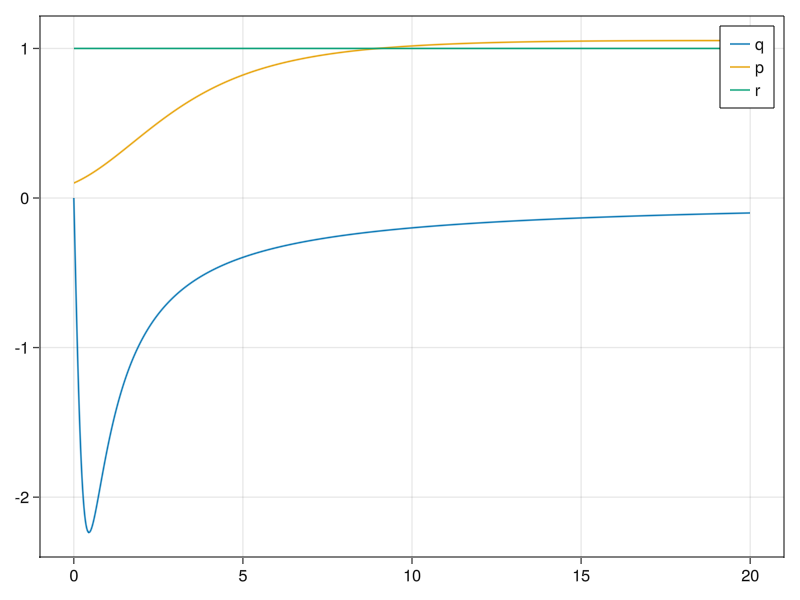

In [31]:
if plot_s
    x = range(par[1], par[2], length=1000)
    yq = q.(x)
    yp = p.(x)
    yr = r.(x)
    lines(x, yq, label= "q")
    lines!(x, yp, label= "p")
    lines!(x, yr, label= "r")
    axislegend()
    current_figure()
end

Now we define the variational problem

In [12]:
a(u,v) = ∫(p*∇(v)⋅∇(u) + q*v*u)*dΩ; # deben verificar la integración por partes
m(u,v) = ∫(r*u*v)dΩ;

m (generic function with 1 method)

Here we introduce the solver and its parámeters, and the solve the system.

In [13]:
include("eigen.jl")

solve (generic function with 1 method)

In [14]:
nev = 12 # number of eigenvalues asked to evaluate.
prob = EigenProblem(a, m, U, V; nev=nev, tol=10^(-6), maxiter=100, explicittransform=:none, sigma=-1.0)
#prob = EigenProblem(a, m, U, V; nev=nev, which=:LM, explicittransform=:auto, tol=10^(-6), maxiter=100, sigma=0)
ξ, uₕs = solve(prob);


We now illustrate how to manipulate the solutions (eigenfunctions and eigenvalues)

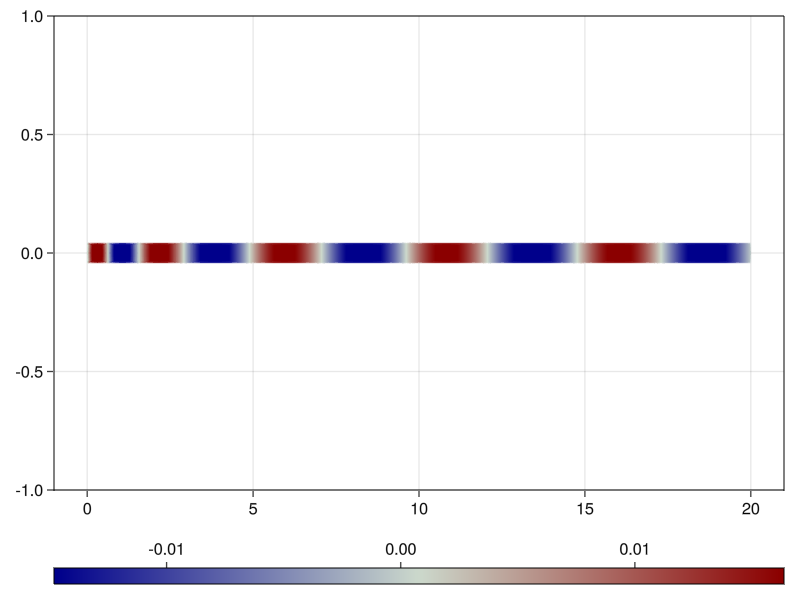

In [35]:
uₕ = uₕs[10]
fig, ax, plt = plot(Ω, real(uₕ), linewidth=20)
#ax.aspect = AxisAspect(1)
Colorbar(fig[2,1], plt, vertical=false)
fig

Mostramos las autofunciones numéricas

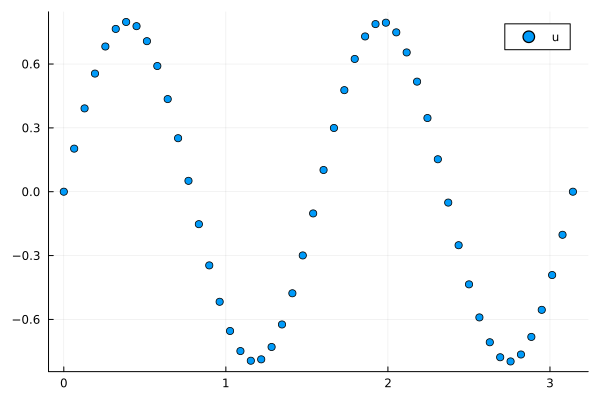

In [36]:
x = range(par[1], par[2], length=50)
scatter(x, evaluate(real(uₕ),Gridap.Point.(x)), label= "u")

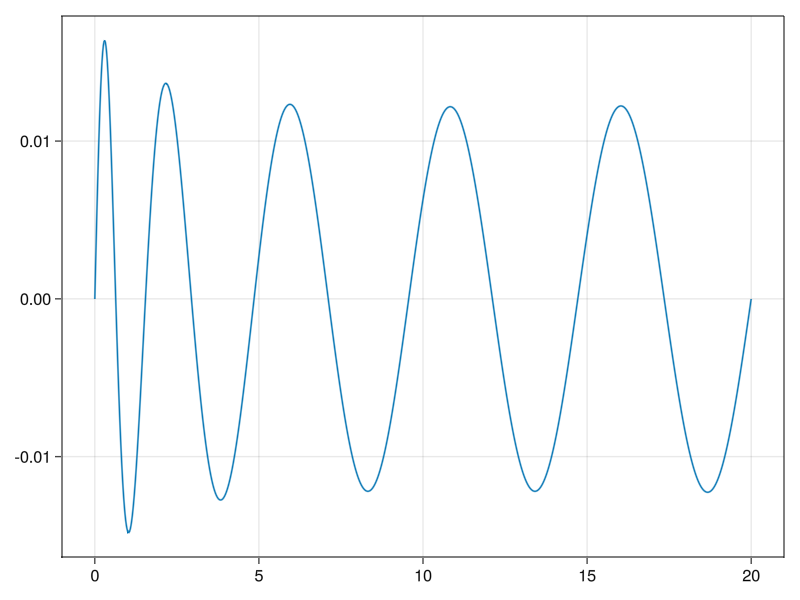

In [36]:
x = range(par[1], par[2], length=1000)
lines(x, evaluate(real(uₕ),Gridap.Point.(x)), label= "u")

#=
    usamos evaluate() para interpolar la autofunción uₕ a los puntos de la grilla x
=#

In [37]:
fig = Figure()

ax = Axis(fig[1, 1], xlabel = "eigenvalue number", ylabel = "value",
    title = "Eigenvalues", yscale = log10, xscale = log10)

scatter!(sort(real(ξ[1:nev])), label = "computed")

if test_1
    scatter!(ax,[n^2 for n ∈ 1:nev], marker=:star8, label = "true")
elseif test_2
    scatter!([(n*π/log(L))^2 for n ∈ 1:nev], marker=:star8, label = "true")
elseif test_3
    scatter!([1 + 2*(n-1) for n ∈ 1:nev], marker=:star8, label = "true")
end
axislegend()
current_figure()
fig

In [15]:
ξ

12-element Vector{ComplexF64}:
 0.9999999999965778 + 5.557643391907835e-16im
  4.000000000111585 + 6.926667583937154e-16im
  9.000000001258115 - 8.778849686070877e-16im
   16.0000000070722 + 2.006513959300238e-15im
 25.000000027001146 - 1.72199329360744e-15im
 36.000000080637484 + 1.236555599385031e-14im
  49.00000020334912 + 1.218811345554713e-14im
  64.00000045309585 + 4.165679616039316e-15im
  81.00000091853552 - 1.5138181335942316e-14im
 100.00000172834038 - 5.150138754359461e-15im
 121.00000306176841 - 6.020602782811226e-14im
 144.00000516046677 + 8.171666734918167e-15im

And here we can save them into a file to see it with visit, for instance. 

In [18]:
using Plots;

if test_1 || test_2 || test_3
    n=4 # for test_3 use n=4

    uₕ = uₕs[n]
    # normalize the eigenvalue
    u2 = sum(∫(uₕ*uₕ)*dΩ)
    uₕ = uₕ/sqrt(u2)

    if test_1
        u_n(x) = -sin(n*x)/sqrt(π/2)
    elseif test_2
        freq=n*π/log(L)
        u_n(x) = sqrt((4*freq^2+1)/(2(L-1)*freq^2))*sin(freq*log(x))
    elseif test_3
        u_n(x) = -exp(-x^2/2)*(8x^3-12x)/sqrt(85.0778) 
    end

    # x = range(par[1], par[2], length=1000)
    # scatter(x, evaluate(real(uₕ),Gridap.Point.(x)), label= "computed")
    # lines!(x, u_n.(x), label= "exact")
    # scatter!(x, 100000*(evaluate(real(uₕ),Gridap.Point.(x))-u_n.(x)), label= "error x 10^5")
    # axislegend()
    # current_figure()   
end

u_n (generic function with 1 method)

In [ ]:
writevtk(Ω,"images/P01_test1_solución_un",cellfields=["un" => real(uₕ)]);

In [40]:
typeof(nothing);

Nothing

In [44]:
eigs

eigs (generic function with 8 methods)